In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import numpy as np
import pandas as pd
import h5py
from tqdm import tqdm
import scipy.io as sio
from scipy import stats
from importlib import reload
from matplotlib import pyplot as plt
import sys
sys.path.append('/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/')
import python_utils_jjm as utils_jjm
import dlc_utils
import caiman
import statsmodels.formula.api as smf

/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of 

In [2]:
reload(utils_jjm)

<module 'python_utils_jjm' from '/Users/johnmarshall/Documents/Analysis/PythonAnalysisScripts/post_cmfe_analysis/python_utils_jjm.py'>

In [3]:
cnmfe_file_key = pd.read_csv('/volumes/My_Passport/dlc_analysis/behavcamvideos/cnmfe_file_key.csv')

In [4]:
cnmfe_base_dir = '/Volumes/My_Passport/cnmfe_analysis_files/batch_output_files/'
wt_CNMFE_file = ['30-Mar_20_39_05_out.mat', '30-Mar_20_45_16_out.mat', '27-Feb_17_33_59_out.mat', '22-Mar_22_52_02_out.mat',
                 '28-Feb_16_10_05_out.mat', '27-Feb_17_32_15_out.mat', '28-Feb_16_21_21_out.mat', '25-Mar_13_27_27_out.mat',
                 '25-Mar_14_22_02_out.mat', '25-Mar_14_22_44_out.mat', '26-Mar_18_33_55_out.mat', '27-Mar_00_26_12_out.mat', '27-Mar_00_48_46_out.mat']

ko_CNMFE_files = ['31-Mar_13_28_15_out.mat', '29-Mar_21_42_20_out.mat', '13-Apr_17_57_40_out.mat', '29-Mar_14_27_55_out.mat', '13-Apr_16_01_20_out.mat',
                 '13-Apr_16_11_27_out.mat', '29-Mar_13_39_44_out.mat']

In [5]:
tracking_files = ['/volumes/My_Passport/dlc_analysis/behavcamvideos/'+utils_jjm.find_behavior_tracking(fname, cnmfe_file_key) for fname in ko_CNMFE_files] 

In [43]:
#tracking_files

In [44]:
CNMFE_dir_paths_list = [str(cnmfe_base_dir+fname) for fname in ko_CNMFE_files]
#CNMFE_dir_paths_list

In [56]:
binning_time = 1 # seconds 
body_part_for_tracking = 'tail_base' #
number_of_bins = 50 #
polynomial_degree = 2 #

group_results_binning = {}
success = []
failed = []
for CNMFE_file, tracking_file in zip(CNMFE_dir_paths_list, tracking_files):
    #print(CNMFE_file)
    #print(tracking_file)
    try:
        # create time deltas
        C_z_scored, interpolated = utils_jjm.prepare_timedelta_dfs(CNMFE_file, tracking_file)
        # downsample and bin
        cells_C_binned_by_V, cells_mean_C_binned_by_V = dlc_utils.downsample_session_and_bin_C_by_V(binning_time, number_of_bins, body_part_for_tracking, interpolated, C_z_scored)
        # add save step here?
        group_results_binning[tracking_file] = {'C_z_scored':C_z_scored, 'tracking_data' :interpolated, 
                                              'C_binned_by_V':cells_C_binned_by_V, 'C_binned_by_V_means':cells_mean_C_binned_by_V}
        success.append((tracking_file.split('/')[-2], CNMFE_file.split('/')[-1]))
    except FileNotFoundError:
        failed.append(tracking_file)
        

regression_results_by_group = {}
for tracking_file in list(group_results_binning.keys()):
    # add regression results
    regression_results = dlc_utils.create_regression_models_per_cell(group_results_binning[tracking_file]['C_binned_by_V_means'], polynomial_degree)
    regression_results_by_group[tracking_file.split('/')[-2]] = regression_results

## get some summaries of regression info by groups
grouped_info = {}
grouped_info_means = {}
for session in session_names:
    info_by_session = {}
    info_by_session_means = {}
    session_results = regression_results_by_group[session]
    # F statistics
    F_stats_by_session = np.array([float(session_results[cell]['statsmodel_results'].summary().tables[0][3][3].data) 
                    for cell in range(1, len(session_results)+1)])
    info_by_session['F_stats'] = F_stats_by_session
    info_by_session_means['total_cells'] = len(F_stats_by_session)
    # r2
    r_stats_by_session = np.array([float(session_results[cell]['statsmodel_results'].summary().tables[0][3][3].data) 
                    for cell in range(1, len(session_results)+1)])
    info_by_session['R-squared'] = r_stats_by_session
    info_by_session_means['R-squared_mean'] = np.mean(r_stats_by_session)
    # significant regressions
    significant_regressions = len(np.argwhere(F_stats_by_session<0.05))
    info_by_session_means['significant_regressions'] = significant_regressions 
    
    #proportion of significant regressions 
    percent_significant = (significant_regressions/len(F_stats_by_session))*100
    info_by_session_means['percent_significant'] = percent_significant
    #print('percent significant')
    #print(percent_significant)
    grouped_info[session] = info_by_session
    grouped_info_means[session] = info_by_session_means
    
grouped_info_means = pd.DataFrame(grouped_info_means)
grouped_info = pd.DataFrame(grouped_info_means)

/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/johnmarshall/anaconda3/envs/caiman/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [57]:
grouped_info_means

,GRIN009_H13_M59_S14,GRIN018_H17_M41_S43,GRIN018_H16_M13_S53,GRIN011_H10_M19_S59,GRIN012_H17_M32_S17,GRIN012_H16_M57_S23
total_cells,404.000000,148.000000,45.000000,264.000000,58.000000,88.000000
R-squared_mean,0.254531,0.044873,0.149592,0.189125,0.139609,0.088225
significant_regressions,118.000000,126.000000,20.000000,89.000000,29.000000,53.000000
percent_significant,29.207921,85.135135,44.444444,33.712121,50.000000,60.227273


In [58]:
grouped_info_means.mean(axis=1)

total_cells                167.833333
R-squared_mean               0.144326
significant_regressions     72.500000
percent_significant         50.454482
dtype: float64

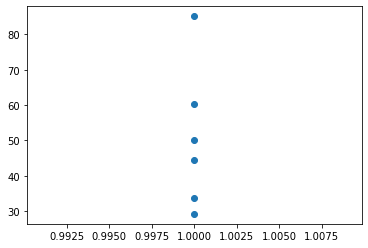

In [59]:
plt.scatter(np.ones(len(grouped_info_means.loc['percent_significant'].values)), grouped_info_means.loc['percent_significant'].values)

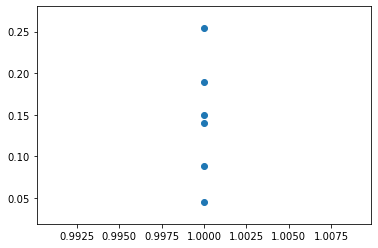

In [60]:
plt.scatter(np.ones(len(grouped_info_means.loc['R-squared_mean'].values)), grouped_info_means.loc['R-squared_mean'].values)